![](https://storage.googleapis.com/kaggle-media/competitions/dsb-2018/dsb.jpg)

# 0. Intro
### Основная идея: Делаем решение на базе U-Net

In [1]:
import os
import sys
import glob
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)

INFO:tensorflow:Using local port 18444
INFO:tensorflow:Using local port 17952
INFO:tensorflow:Using local port 18223
INFO:tensorflow:Using local port 19960
INFO:tensorflow:Using local port 22219
INFO:tensorflow:Using local port 24469
INFO:tensorflow:Using local port 16196
INFO:tensorflow:Using local port 16339
INFO:tensorflow:Using local port 21888
INFO:tensorflow:Using local port 20515
Python       : 3.8.5 (default, Jul 28 2020, 12:59:40) 
Numpy        : 1.18.5
Skimage      : 0.17.2
Keras        : 2.4.3
Tensorflow   : 2.4.0


In [2]:
# seed values
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# SETUP

In [4]:
# SETUP
TRAIN_PATH = '/home/alex/skill-factory/DL-7/data/train/'
TEST_PATH = '/home/alex/skill-factory/DL-7/data/test/'

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 3

BATCH_SIZE      = 32
NUM_EPOCHS      = 50
# STEPS_PER_EPOCH = 600
LR              = 1e-5
validation_split= 0.1

# 1. Load Data
распаковываем данные

Для начала глянем csv

In [5]:
sample_submission = pd.read_csv('~/skill-factory/DL-7/data/input/sample_submission.csv')
sample_submission.sample(5)

,ImageId,EncodedPixels
53,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,1 1
60,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,1 1
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,1 1
45,a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...,1 1
5,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,1 1


In [6]:
len(sample_submission)

65

Не кажется странным, что нам предлагают на тест только 65 уникальных картинок? )  
посмотрим что в трейне...

In [7]:
train_labels = pd.read_csv('~/skill-factory/DL-7/data/input/train_labels.csv')
train_labels.sample(10)

,ImageId,EncodedPixels
16141,8b77284d6f37ab3fc826139ebadaec3b9d81c552fe525c...,55530 7 55784 12 56039 14 56294 16 56549 18 56...
27194,ea94ba4b01d1bd5f7768d10e0ac547743791033df545c7...,12295 8 12550 11 12805 14 13060 17 13316 18 13...
24216,cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9...,37435 5 37690 7 37945 8 38201 8 38457 8 38713 ...
25304,da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e751...,18647 6 19166 8 19686 9 20206 9 20726 8 21247 ...
21273,b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d4...,331026 5 331543 9 332062 12 332580 15 333099 1...
9796,538b7673d507014d83af238876e03617396b70fe27f525...,127462 4 128064 8 128666 12 129268 16 129870 2...
3410,1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526...,431986 4 433009 5 434033 5 435057 6 436081 6 4...
16126,8aa1a883f61f0bb5af3d3d60acaaf33af45ef4fbffaac1...,59092 3 59345 8 59600 11 59856 11 60112 11 603...
9577,4e23ecf65040f86420e0201134e538951acdeda84fbb27...,55041 2 55297 4 55553 5 55809 6 56065 6 56321 ...
27756,ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5...,23588 3 23843 5 24099 5 24355 5 24612 3


In [8]:
len(train_labels)

29461

в описании датасета написано что "Каждая маска содержит одно ядро."  
А из всех 29к примеров, сколько у нас уникальных изображений для тренировки на самом деле?

In [9]:
len(train_labels) - train_labels.ImageId.duplicated().sum()

670

Сверяем по папкам

In [10]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))
test_ids = next(os.walk(TEST_PATH))

mask_count = 0
for train_id in train_ids[1]:
    masks = next(os.walk(TRAIN_PATH + train_id + '/masks/'))[2]
    mask_count += len(masks)

print('There are {} images.'.format(len(train_ids[1])))
print('There are {} masks.'.format(mask_count))
print('Approximately {} masks per image.'.format(mask_count // len(train_ids[1])))

There are 670 images.
There are 29461 masks.
Approximately 43 masks per image.


Вот все и встало на свои места, Итого 65 изображений на тесте и 670 на трейне.  
Давай подгрузим и посмотрим эти картинки

In [11]:
# для подгрузки данных будем использовать удобную либу skimage
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], 
                                                output_shape=output_shape, 
                                                mode='constant', 
                                                preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data

In [12]:
%%time
# Get training data
X_train = get_X_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(X_train.shape, X_train.dtype)

(670, 256, 256, 3) uint8
CPU times: user 9.58 s, sys: 10.1 s, total: 19.7 s
Wall time: 6.69 s


In [13]:
def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data

In [14]:
%%time
# Get training data labels
Y_train = get_Y_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
Y_train = tf.cast(Y_train, tf.float32)
print(Y_train.shape, Y_train.dtype)

(670, 256, 256, 1) <dtype: 'float32'>
CPU times: user 35.1 s, sys: 23.8 s, total: 58.9 s
Wall time: 28.9 s


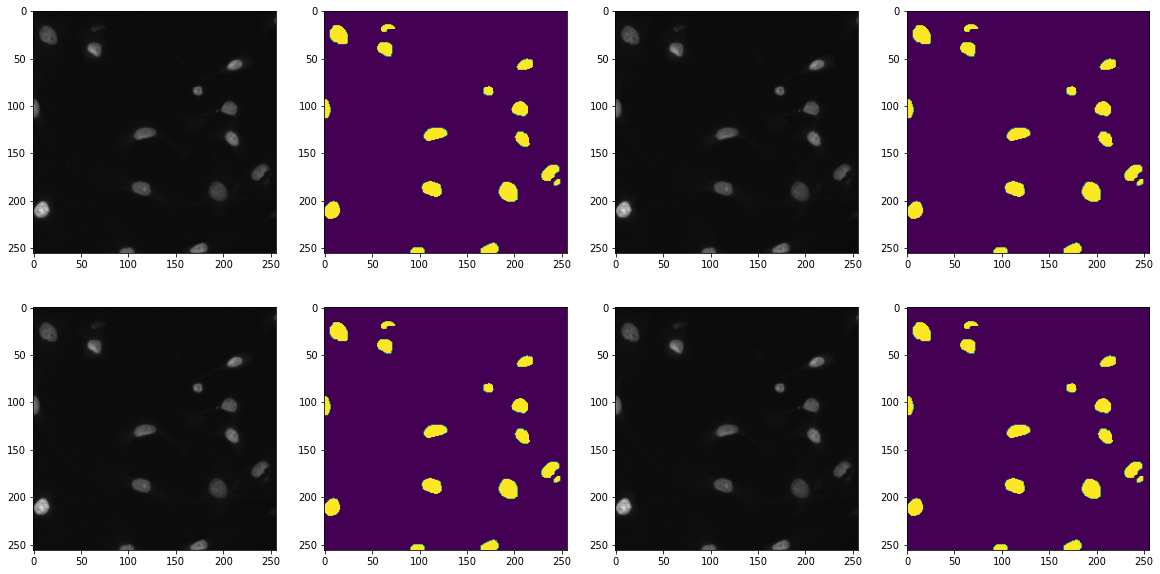

In [15]:
# Check training data
f, axarr = plt.subplots(2,4)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,1].imshow(np.squeeze(Y_train[ix]))

axarr[0,2].imshow(X_train[ix])
axarr[0,3].imshow(np.squeeze(Y_train[ix]))

axarr[1,0].imshow(X_train[ix])
axarr[1,1].imshow(np.squeeze(Y_train[ix]))

axarr[1,2].imshow(X_train[ix])
axarr[1,3].imshow(np.squeeze(Y_train[ix]))

plt.show()

# 2. Build model

> Построим U-Net model, по мотивам [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) и близко к этому [репозиторию](https://github.com/jocicmarko/ultrasound-nerve-segmentation) из Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [16]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


In [19]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
#c5 = BatchNormalization() (c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
optimizer = Adam(lr=LR,)
model.compile(optimizer=optimizer, loss=dice_coef_loss)
model.summary()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [20]:
# Fit model
history = model.fit(X_train, Y_train, 
                    validation_split=validation_split, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    verbose=2,)

Epoch 1/50
19/19 - 8s - loss: 0.1632 - val_loss: 0.1541
Epoch 2/50
19/19 - 2s - loss: 0.1464 - val_loss: 0.1387
Epoch 3/50
19/19 - 2s - loss: 0.1290 - val_loss: 0.1212
Epoch 4/50
19/19 - 2s - loss: 0.1115 - val_loss: 0.1046
Epoch 5/50
19/19 - 2s - loss: 0.0974 - val_loss: 0.0922
Epoch 6/50
19/19 - 2s - loss: 0.0881 - val_loss: 0.0857
Epoch 7/50
19/19 - 2s - loss: 0.0831 - val_loss: 0.0830
Epoch 8/50
19/19 - 2s - loss: 0.0808 - val_loss: 0.0819
Epoch 9/50
19/19 - 2s - loss: 0.0795 - val_loss: 0.0813
Epoch 10/50
19/19 - 2s - loss: 0.0787 - val_loss: 0.0808
Epoch 11/50
19/19 - 2s - loss: 0.0779 - val_loss: 0.0802
Epoch 12/50
19/19 - 2s - loss: 0.0766 - val_loss: 0.0789
Epoch 13/50
19/19 - 2s - loss: 0.0742 - val_loss: 0.0763
Epoch 14/50
19/19 - 2s - loss: 0.0726 - val_loss: 0.0767
Epoch 15/50
19/19 - 2s - loss: 0.0717 - val_loss: 0.0760
Epoch 16/50
19/19 - 2s - loss: 0.0710 - val_loss: 0.0763
Epoch 17/50
19/19 - 2s - loss: 0.0705 - val_loss: 0.0759
Epoch 18/50
19/19 - 2s - loss: 0.0700 - 

In [21]:
model.save('keras_unet.hdf5')

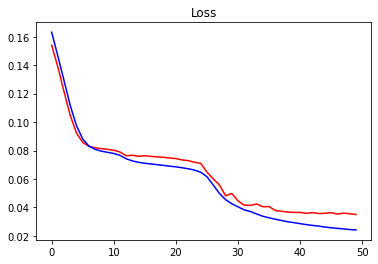

In [22]:
def plot_loss_history(history):
    # validation losses
    val_loss = history.history['val_loss']
    loss = history.history['loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.show()
    
plot_loss_history(history)

# 3. Make predictions

In [23]:
# Use model to predict train labels
#model = load_model('keras_unet.hdf5',)
Y_predict = model.predict(X_train, verbose=1)
Y_predict.shape

21/21 [==============================] - 1s 52ms/step


(670, 256, 256, 1)

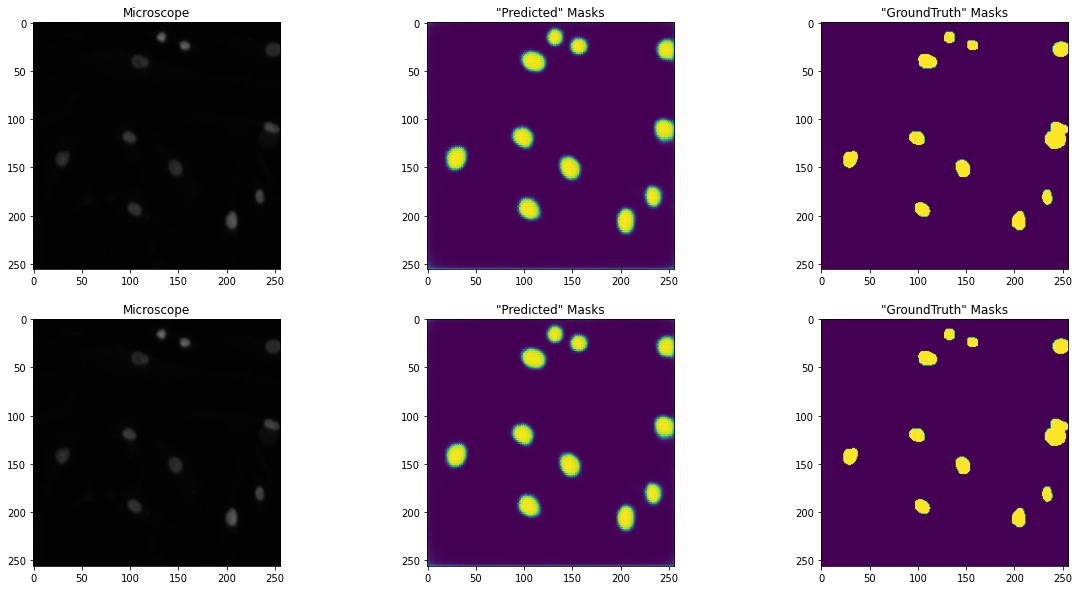

In [24]:
# Check predict data
f, axarr = plt.subplots(2,3)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,0].set_title('Microscope')
axarr[0,1].imshow(np.squeeze(Y_predict[ix]))
axarr[0,1].set_title('"Predicted" Masks')
axarr[0,2].imshow(np.squeeze(Y_train[ix]))
axarr[0,2].set_title('"GroundTruth" Masks')

axarr[1,0].imshow(X_train[ix])
axarr[1,0].set_title('Microscope')
axarr[1,1].imshow(np.squeeze(Y_predict[ix]))
axarr[1,1].set_title('"Predicted" Masks')
axarr[1,2].imshow(np.squeeze(Y_train[ix]))
axarr[1,2].set_title('"GroundTruth" Masks')

plt.show()

Смотриться хорошо

In [25]:
# Get test data
X_test = get_X_data(TEST_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))

# Use model to predict test labels
Y_hat = model.predict(X_test, verbose=1)
Y_hat.shape

3/3 [==============================] - 0s 132ms/step


(65, 256, 256, 1)

(256, 256, 3)


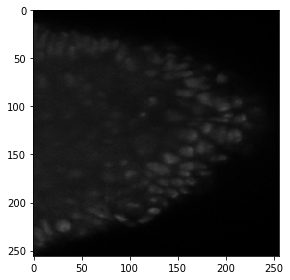

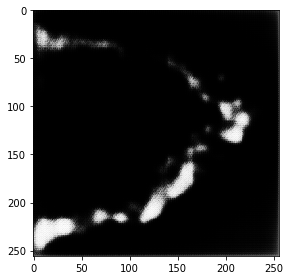

In [26]:
idx = random.randint(0, len(test_ids[1]))
print(X_test[idx].shape)
skimage.io.imshow(X_test[idx])
plt.show()
skimage.io.imshow(Y_hat[idx][:,:,0])
plt.show()

# 4. Encode and Submit

In [27]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

мы ресайзили картинку до 256х256, но чтоб верно предсказать, нам нужно сделать маску под размер изначальной картинки

In [28]:
# Upsample Y_hat back to the original X_test size (height and width)
Y_hat_upsampled = []
for i, test_id in enumerate(os.listdir(TEST_PATH)):  #loop through test_ids in the test_path
    img = skimage.io.imread('{0}/{1}/images/{1}.png'.format(TEST_PATH, test_id))  #read original test image directly from path
    img_upscaled = skimage.transform.resize(Y_hat[i], (img.shape[0], img.shape[1]), mode='constant', preserve_range=True)  #upscale Y_hat image according to original test image
    Y_hat_upsampled.append(img_upscaled)   #append upscaled image to Y_hat_upsampled
len(Y_hat_upsampled)

65

Осталось закодировать нашу маску

In [29]:
# Apply Run-Length Encoding on our Y_hat_upscaled
new_test_ids = []
rles = []
for n, id_ in enumerate(os.listdir(TEST_PATH)):
    rle = list(prob_to_rles(Y_hat_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
len(new_test_ids)  #note that for each test_image, we can have multiple entries of encoded pixels

1287

In [30]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission.csv', index=False)

In [31]:
sub.head()

,ImageId,EncodedPixels
0,a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...,127 17 645 21 1164 21 1680 25 2198 29 2714 32 ...
1,a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...,260 7 776 12 1294 13 1810 19 2328 21 2844 25 3...
2,a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...,382 21 899 22 1417 24 1931 32 2450 33 2966 36 ...
3,a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...,438 29 954 29 1473 29 1503 2 1988 36 2506 38 3...
4,a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...,2094 4 2101 4 2610 19 3128 22 3647 1 3649 21 4...


In [32]:
len(sub)

1287

Готово!

## Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Добавить свою метрику (для сегментации loss не лучшая метрика) и callbacks по ней
* Поставить и подобрать Threshold для predictions
* Добавить аугментацию
* Поиграться с архитектурой
* Подобрать другие переменные (размер картинки, батч и тп)
* Добавить политику обучения
* Добавить TTA
* Найти и обучиться на других внешних данных
* Построить ансамбль из разных архитектур

Удачи в соревновании!